In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import nltk

# Dataset

In [ ]:
!git clone https://github.com/cocodataset/cocoapi.git
!cd cocoapi/PythonAPI; make; python setup.py install;

In [4]:
!apt-get install axel

Reading package lists... Done
Building dependency tree       
Reading state information... Done
axel is already the newest version (2.17.5-1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.


In [ ]:
!axel -n 5 http://images.cocodataset.org/zips/train2017.zip
!axel -n 5 http://images.cocodataset.org/annotations/annotations_trainval2017.zip

In [14]:
!ls -lh /content/train2017.zip

-rw-r--r-- 1 root root 19G Feb  5 16:07 /content/train2017.zip


In [ ]:
!unzip train2017

In [ ]:
!unzip annotations_trainval2017

In [20]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = torchvision.datasets.CocoCaptions(root='./train2017', annFile='./annotations/captions_train2017.json', transform=preprocess)

loading annotations into memory...
Done (t=0.87s)
creating index...
index created!


In [ ]:
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Processing Texts

In [22]:
import pandas as pd
import json

In [43]:
import string
import re


def tokenize_text(text):
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # remove extra spaces
    text = re.sub(' +', ' ', text)
    # remove leading and trailing spaces
    text = text.strip()
    # convert to lowercase
    text = text.lower()
    return text.split(' ')

In [31]:
start, end, pad, unkown = '<s>', '</s>', '<pad>', '<unk>'

In [24]:
with open('./annotations/captions_train2017.json') as f:
    captions = json.load(f)

In [75]:
dictionary = []
max_len = 0

for item in captions['annotations']:
    caption_tokens = tokenize_text(item['caption'])
    max_len = max(max_len, len(caption_tokens))
    dictionary.extend(caption_tokens)

In [134]:
dictionary = list(set(dictionary).union([start, end, pad, unkown]))

In [135]:
word2idx = {word: i for i, word in enumerate(dictionary)}
idx2word = {i: word for word, i in word2idx.items()}

In [136]:
len(idx2word)

28588

In [137]:
unkown_idx = word2idx[unkown]
pad_idx = word2idx[pad]
start_idx = word2idx[start]
end_idx = word2idx[end]

def words_to_numbers(words):
    return [word2idx.get(word, unkown_idx) for word in words]

def numbers_to_words(numbers):
    words = []
    for number in numbers:
        if number == unkown_idx:
            words.append(unkown)
            continue
        words.append(idx2word[number])
        if number == end_idx:
            break
    return words

In [147]:
class ProcessedCOCO(torchvision.datasets.CocoCaptions):

    def __init__(self, *args, **kwargs):
        self.max_len = kwargs.pop('max_len')
        super().__init__(*args, **kwargs)


    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        target_idx = np.random.choice(range(len(target)))
        target = target[target_idx]
        target = tokenize_text(target)
        target = words_to_numbers([start] + target + [end])
        target = torch.tensor(target)
        if len(target) > self.max_len:
            target = target[:self.max_len]
        target = F.pad(target, (0, self.max_len - len(target)), value=pad_idx)
        return img, target

In [148]:
dataset = ProcessedCOCO(root='./train2017', annFile='./annotations/captions_train2017.json', transform=preprocess, max_len=max_len)

loading annotations into memory...
Done (t=1.35s)
creating index...
index created!


In [149]:
caption = dataset[10][1]
numbers_to_words(caption.numpy())

['<s>',
 'the',
 'two',
 'giraffes',
 'appear',
 'to',
 'be',
 'hugging',
 'each',
 'other',
 '</s>']

# Model

In [152]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [153]:
class CaptioningModel(nn.Module):

    def __init__(self, embedding_size, hidden_size, vocab_size, num_layers=1, max_len=50):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        self.cnn = torchvision.models.resnet18(pretrained=True)
        self.cnn_output_size = self.cnn.fc.in_features
        self.image_to_h0 = nn.Linear(self.cnn_output_size, hidden_size)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1], nn.Flatten(), self.image_to_h0)
        self.cnn.eval()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.max_len = max_len



    def forward(self, images, captions):
        h0 = self.cnn(images)
        h0 = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)
        c0 = torch.zeros_like(h0)
        embeddings = self.embedding(captions)
        x, _ = self.lstm(embeddings, (h0, c0))
        x = self.fc(x)
        return x

    def loss(self, images, captions):
        x = self(images, captions)
        captions = captions[:, 1:].reshape(-1)
        x = x[:, :-1].reshape(-1, x.shape[-1])
        loss = F.cross_entropy(x, captions)
        return loss

    def predict(self, images):
        h0 = self.cnn(images)
        h0 = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)
        c0 = torch.zeros_like(h0)
        input_embd = self.embedding(torch.tensor(start_idx).to(device))
        input_embds = input_embd.repeat(images.shape[0], 1, 1)
        result = torch.zeros(images.shape[0], self.max_len, dtype=torch.long)

        words_idxs = torch.arange(self.vocab_size, device=device)

        for i in range(self.max_len):
            x, (h0, c0) = self.lstm(input_embds, (h0, c0))
            x = x.squeeze(1)
            x = self.fc(x)
            probs = F.softmax(x, dim=-1)
            idx = probs.multinomial(1)[:, 0]
            x = words_idxs[idx]
            result[:, i] = x
            input_embds = self.embedding(x).reshape(x.shape[0], 1, -1)
        return result

# Training

In [154]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [166]:
def train(model, train_loader, val_loader, optimizer, epochs, device, name='model.pt', scheduler=None):

    history = {'train': [], 'val': []}
    min_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        with tqdm(val_loader, total=len(val_loader)) as pbar:
            for x, y in pbar:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                loss = model.loss(x, y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * x.shape[0]
                pbar.set_description(f'{epoch}: Train Loss: {train_loss / len(train_loader):.3e}')
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0
        with torch.no_grad(), tqdm(val_loader, total=len(val_loader)) as pbar:
            for x, y in pbar:
                x, y = x.to(device), y.to(device)
                loss = model.loss(x, y)
                val_loss += loss.item() * x.shape[0]
                pbar.set_description(f'{epoch}: Val Loss: {val_loss / len(val_loader):.3e}')
        val_loss /= len(val_loader)

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), name)

        if scheduler:
            scheduler.step(val_loss)
        
        print('-'*70)
        history['train'].append(train_loss)
        history['val'].append(val_loss)

    plt.plot(history['train'], label='train')
    plt.plot(history['val'], label='val')
    plt.legend()
    plt.suptitle('Loss')
    plt.show()

I'm gonna first Overfit on only on tenth of the dataset, in case I run out of GPU :)

In [ ]:
training_len = int(0.1 * len(dataset))
val_len = int(0.01 * len(dataset))
training_data, val_data, _ = torch.utils.data.random_split(dataset, [training_len, val_len, len(dataset) - training_len - val_len])

train_loader = torch.utils.data.DataLoader(training_data, batch_size=2, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=2, shuffle=True, num_workers=2)

In [156]:
model = CaptioningModel(embedding_size=128, hidden_size=256, vocab_size=len(dictionary), num_layers=2, max_len=max_len).to(device)
model.cnn.requires_grad_(False)
model.image_to_h0.requires_grad_(True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=512, out_features=256, bias=True)

0: Val Loss: 2.357e+00: 100%|██████████| 591/591 [00:17<00:00, 33.42it/s]


----------------------------------------------------------------------


1: Val Loss: 2.176e+00: 100%|██████████| 591/591 [00:19<00:00, 30.69it/s]


----------------------------------------------------------------------


2: Val Loss: 2.095e+00: 100%|██████████| 591/591 [00:23<00:00, 24.69it/s]


----------------------------------------------------------------------


3: Val Loss: 1.984e+00: 100%|██████████| 591/591 [00:17<00:00, 33.52it/s]


----------------------------------------------------------------------


4: Val Loss: 1.891e+00: 100%|██████████| 591/591 [00:16<00:00, 35.80it/s]


----------------------------------------------------------------------


5: Val Loss: 1.865e+00: 100%|██████████| 591/591 [00:18<00:00, 32.65it/s]


----------------------------------------------------------------------


6: Val Loss: 1.806e+00: 100%|██████████| 591/591 [00:16<00:00, 35.82it/s]


----------------------------------------------------------------------


7: Val Loss: 1.789e+00: 100%|██████████| 591/591 [00:17<00:00, 33.24it/s]


----------------------------------------------------------------------


8: Val Loss: 1.687e+00: 100%|██████████| 591/591 [00:16<00:00, 35.53it/s]


----------------------------------------------------------------------


9: Val Loss: 1.635e+00: 100%|██████████| 591/591 [00:16<00:00, 35.78it/s]


----------------------------------------------------------------------


10: Val Loss: 1.585e+00: 100%|██████████| 591/591 [00:19<00:00, 30.36it/s]


----------------------------------------------------------------------


11: Val Loss: 1.536e+00: 100%|██████████| 591/591 [00:16<00:00, 36.10it/s]


----------------------------------------------------------------------


12: Val Loss: 1.504e+00: 100%|██████████| 591/591 [00:16<00:00, 34.88it/s]


----------------------------------------------------------------------


13: Val Loss: 1.487e+00: 100%|██████████| 591/591 [00:16<00:00, 35.41it/s]


----------------------------------------------------------------------


14: Val Loss: 1.409e+00: 100%|██████████| 591/591 [00:17<00:00, 34.35it/s]


----------------------------------------------------------------------


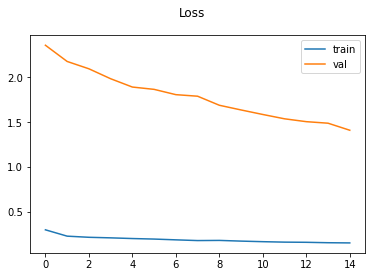

In [157]:
epochs = 15
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, train_loader, val_loader, optimizer, epochs, device)

# Evaluate

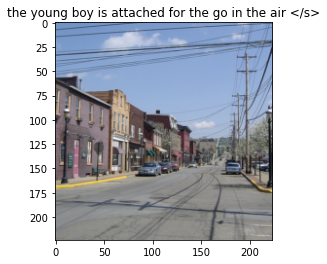

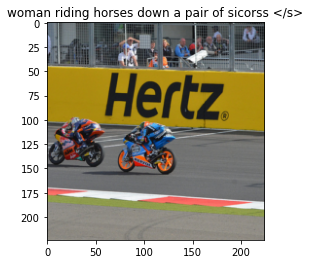

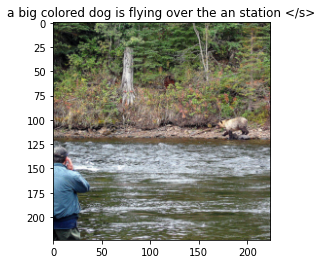

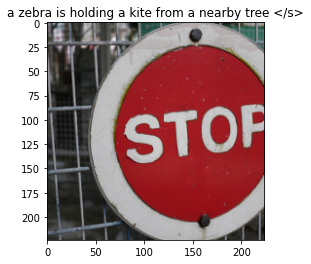

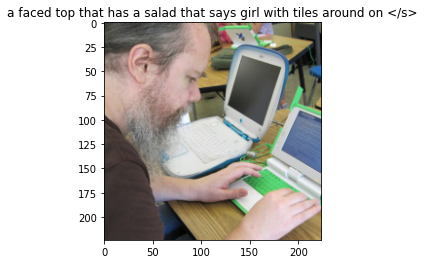

In [165]:
# sample a few captions
topil = torchvision.transforms.ToPILImage()
mean=np.array([0.485, 0.456, 0.406])[:, None, None]
std=np.array([0.229, 0.224, 0.225])[:, None, None]
model.eval()

for i in range(5):
    idx = np.random.randint(len(training_data))
    image, caption = training_data[idx]
    image = image.unsqueeze(0).to(device)
    caption = caption.unsqueeze(0).to(device)
    predicted_caption = model.predict(image)
    predicted_caption = predicted_caption[0].cpu().numpy()
    predicted_caption = numbers_to_words(predicted_caption)
    predicted_caption = ' '.join(predicted_caption)
    image = image[0].cpu()
    image = image * std + mean
    image = topil(image)
    plt.imshow(image)
    plt.title(predicted_caption)
    plt.show()
    print()

Training on all of data:

In [167]:
training_len = int(0.85 * len(dataset))
val_len = int(0.15 * len(dataset))
training_data, val_data, _ = torch.utils.data.random_split(dataset, [training_len, val_len, len(dataset) - training_len - val_len])

train_loader = torch.utils.data.DataLoader(training_data, batch_size=2, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=2, shuffle=True, num_workers=2)

In [168]:
model = CaptioningModel(embedding_size=128, hidden_size=256, vocab_size=len(dictionary), num_layers=2, max_len=max_len).to(device)
model.cnn.requires_grad_(False)
model.image_to_h0.requires_grad_(True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=512, out_features=256, bias=True)

In [ ]:
epochs = 10
lr = 2e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True)
train(model, train_loader, val_loader, optimizer, epochs, device, scheduler=scheduler)

0: Val Loss: 1.791e+00: 100%|██████████| 8872/8872 [04:17<00:00, 34.48it/s]


----------------------------------------------------------------------


1: Train Loss: 1.331e-01:  43%|████▎     | 3783/8872 [02:10<02:24, 35.17it/s]

I ran out of GPU and Google keeps blocking my accounts access to GPU, so I'm going to stop here.  
Moreover, I couldn't tune my hyperparameters in order to overfit on the small dataset either.